## **To recreate study results please load package versions found in main_requirements.txt**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.8.3 pynndescent==0.5.13


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc

## **Load raw UMI count data**

In [3]:
# read in count matrices post nuclei and gene quality control
adata = sc.read( "../data/Processed_data_RNA-all_full-counts-and-downsampled-CPM.h5ad")

In [4]:
# read in adata post clustering and dev-traj assignment
adata2 = sc.read_h5ad( "../data/Processed_data_RNA-gaba_full-counts-and-downsampled-CPM.h5ad")

In [5]:
adata.obs_names.values

array(['AAACCTGAGAGTCGGT-RL1612_34d_v2', 'AAACCTGAGCCGCCTA-RL1612_34d_v2',
       'AAACCTGAGTCGAGTG-RL1612_34d_v2', ...,
       'TTTGTTGGTAAGGTCG-RL2132_25yr_v3',
       'TTTGTTGGTTCGGCTG-RL2132_25yr_v3',
       'TTTGTTGTCGTCCTCA-RL2132_25yr_v3'], dtype=object)

In [6]:
# add obs and obsm data to matching raw count nuclei
adata = adata[nmc.member_test( adata.obs_names.values, adata2.obs_names.values)]
adata.obs = adata2.obs
adata.obsm = adata2.obsm
adata.uns = adata2.uns
sc.pp.calculate_qc_metrics( adata, inplace=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
# check if order of BCs match, should sum to 0
(adata.obs_names.values!=adata2.obs_names.values).sum()

0

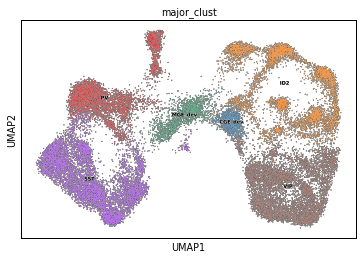

In [8]:
sc.pl.umap( adata, color=['major_clust'], legend_fontsize=5, add_outline=True, legend_loc='on data', size=2, legend_fontoutline=0.5)

## **Clean up features a bit**

In [9]:
# change unknown NaNs in year collected to common date
adata.obs['Collection_year'].fillna( 9999, inplace=True)

/var/folders/cy/tl1lfdqj7rd2_tx7n2kj_vdr0000gn/T/ipykernel_39383/3648978272.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['Collection_year'].fillna( 9999, inplace=True)


In [10]:
# get list of batches
batches = adata.uns['batch_order']

## **Combine by batch and feature of interest**

In [11]:
# we want to pseudo bulk by batch, major dev-traj, and a feature of interest (foi)
# in this case we want to separate out by stage id for each major dev-traj
foi = 'stage_id'
# get list of unique major clusters and define trajs with common developmental clusters
major_clusts = np.unique( adata.obs['major_clust'])
exs = ['L2-3_CUX2','L4_RORB','L5-6_THEMIS'] #,'L5-6_TLE4']
cge = ['VIP','ID2']
mge = ['SST','PV','LAMP5_NOS1','PV_SCUBE3']
major_clusts

array(['CGE_dev', 'ID2', 'MGE_dev', 'PV', 'SST', 'VIP'], dtype=object)

In [12]:
!mkdir ../data/limma-voom

mkdir: ../data/limma-voom: File exists


In [13]:
# set minimum number of nuclei needed to make a bulk data set
min_cells = 10
# loop through major clusters
for dev_itr in major_clusts:
    ### get major dev-traj mask
    # if dev cluster skip
    if( dev_itr in ['PN_dev','CGE_dev','MGE_dev']):
        continue
    # add developing clusters to correct major cluster
    elif( dev_itr in exs):
        dev_mk = np.in1d( adata.obs['major_clust'], [dev_itr,'PN_dev'])
    elif( dev_itr in cge):
        dev_mk = np.in1d( adata.obs['major_clust'], [dev_itr,'CGE_dev'])
    elif( dev_itr in mge):
        dev_mk = np.in1d( adata.obs['major_clust'], [dev_itr,'MGE_dev'])
    else:
        dev_mk = (adata.obs['major_clust']==dev_itr).values
            
    adata_itr = adata[dev_mk]
    #######################################
    # get feature of interest and batches to be bulked
    foi_itr  = adata_itr.obs[foi].unique()
    # add unique label to each bulked stage--batch
    index = [('--').join([x,y]) for x in foi_itr for y in batches]
    # combine ENSG and common gene symbol, will separate once in R
    columns = [ ("--").join((x,y)) for x,y in zip( adata_itr.var['gene_ids'].values, adata_itr.var_names.values)]#
    bulk = pd.DataFrame( index=index, columns=columns)
    ######
    # only want observations that are same across a batch, i.e. observations we can control for
    obs_col_mk = (adata_itr.obs.nunique()<=len(batches)).values
    obs_cols = np.array( adata_itr.obs_keys())[obs_col_mk]
    # drop all dev_traj observations
    obs_cols = [ii for ii in obs_cols if 'traj' not in ii]
    ######
    bulk = pd.DataFrame( index=index, columns=columns)
    obs = pd.DataFrame(  index=index, columns=obs_cols)
    obs['Num_Cells'] = 0
    obs['sub_clust'] = "NaN"
    ######
    for clust_itr in foi_itr:
        clust_mk = adata_itr.obs[foi].values==clust_itr
        clust_adata = adata_itr[clust_mk]
        for batch_itr in batches:
            ind = ('--').join([clust_itr,batch_itr])
            batch_mk = clust_adata.obs['batch'].values==batch_itr
            num_cells = batch_mk.sum()
            if( num_cells<min_cells):
                bulk.drop( ind, axis=0, inplace=True)
                obs.drop(  ind, axis=0, inplace=True)
                continue
            else:
                batch_adata = clust_adata[batch_mk]
                bulk.loc[ind] = batch_adata.X.sum(0).A1
                obs.loc[ind,'Num_Cells'] = num_cells
                obs.loc[ind,foi] = clust_itr
                obs.loc[ind,obs_cols] = batch_adata.obs.iloc[0,obs_col_mk]
    ######
    # check for and replace any /'s
    if( "/" in dev_itr):
        save_mk = [itr for itr, ii in enumerate( dev_itr) if ii=="/"]
        dev_itr = list( dev_itr)
        dev_itr[save_mk[0]] = "-"
        dev_itr = ''.join( dev_itr)
    # transpose because R is weird and save files
    bulk.T.to_csv( f"../data/limma-voom/major-dev-traj_{dev_itr}_pseudo-bulk-cts_min{min_cells}.csv")
    obs.to_csv(  f"../data/limma-voom/major-dev-traj_{dev_itr}_obs-cts_min{min_cells}.csv")

In [14]:
# example output, un-transposed
obs.head()

,batch,RL#,age,chem,concat_id,numerical_age,stage_id,Sex,Race,PMI,...,Library Prep Date,Library Prep Lot,leiden,mat/dev,cell_type,major_clust,sub_clust,dev_clust,downstream_dev_clusts,Num_Cells
Neonatal--RL1777_2d_v3,RL1777_2d_v3,RL1777,2d,v3,3,0.005479,Neonatal,F,White,26,...,27.06.2019,4,IN20,mat,CGE,VIP,VIP_ADAMTSL1,VIP_ADAMTSL1,"VIP_dev,CGE_dev",354
Neonatal--RL1612_34d_v2,RL1612_34d_v2,RL1612,34d,v2,0,0.093151,Neonatal,M,AA,5,...,20.11.2018,5,IN16,mat,CGE,VIP,VIP_ABI3BP,VIP_ABI3BP,"VIP_dev,CGE_dev",453
Childhood--RL2125_422d_v3,RL2125_422d_v3,RL2125,422d,v3,19,1.156164,Childhood,F,AA,20,...,24.04.2020,8,IN9,mat,CGE,VIP,VIP_CRH,VIP_CRH,"VIP_dev,CGE_dev",531
Childhood--RL2105_627d_v3,RL2105_627d_v3,RL2105,627d,v3,9,1.717808,Childhood,M,White,25,...,28.03.2020,7,IN20,mat,CGE,VIP,VIP_ADAMTSL1,VIP_ADAMTSL1,"VIP_dev,CGE_dev",386
Childhood--RL1613_2yr_v2,RL1613_2yr_v2,RL1613,2yr,v2,1,2.0,Childhood,M,White,12,...,20.11.2018,5,IN2,mat,CGE,VIP,VIP_HS3ST3A1,VIP_HS3ST3A1,"VIP_dev,CGE_dev",342


In [15]:
# example output, un-transposed
bulk.head()

,ENSG00000238009--RP11-34P13.7,ENSG00000237683--AL627309.1,ENSG00000239906--RP11-34P13.14,ENSG00000228463--AP006222.2,ENSG00000237094--RP4-669L17.10,ENSG00000235146--RP5-857K21.2,ENSG00000230021--RP5-857K21.4,ENSG00000235373--RP11-206L10.3,ENSG00000240618--RP11-206L10.5,ENSG00000228327--RP11-206L10.2,...,ENSG00000218497--ZNF84-1,ENSG00000229631--AL603926.1,ENSG00000220023--AL592183.1,ENSG00000212884--AC011841.1,ENSG00000215615--AL354822.1,ENSG00000268276--AL590523.1,ENSG00000215700--PNRC2-1,ENSG00000215699--SRSF10-1,ENSG00000215635--AC145205.1,ENSG00000251180--CU459201.1
Neonatal--RL1777_2d_v3,2.0,1.0,0.0,28.0,22.0,0.0,75.0,0.0,0.0,6.0,...,1.0,2.0,162.0,0.0,27.0,0.0,4.0,38.0,2.0,0.0
Neonatal--RL1612_34d_v2,0.0,0.0,0.0,19.0,9.0,0.0,19.0,0.0,1.0,0.0,...,1.0,1.0,130.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0
Childhood--RL2125_422d_v3,5.0,0.0,0.0,90.0,62.0,1.0,230.0,0.0,4.0,12.0,...,2.0,17.0,329.0,0.0,18.0,0.0,1.0,10.0,4.0,0.0
Childhood--RL2105_627d_v3,3.0,2.0,0.0,55.0,46.0,0.0,66.0,0.0,0.0,5.0,...,2.0,9.0,478.0,0.0,61.0,0.0,4.0,34.0,2.0,0.0
Childhood--RL1613_2yr_v2,2.0,2.0,0.0,3.0,25.0,0.0,7.0,0.0,1.0,1.0,...,0.0,5.0,57.0,0.0,22.0,0.0,0.0,6.0,0.0,0.0
